<a href="https://colab.research.google.com/github/renad30/KAUST-ACADEMY-stage2/blob/main/day2_Lab_Classification_Advanced_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

> In this notebook we will cover the preprocessing of a tabular data and will use following algorithms:

> 1. Logistic Regression
> 2. Support Vector Machine
> 3. Decision Tree Classifier
> 4. Random Forest Classifier
> 5. XGBoost Classifier
> 6. CatBoost Classifier

---

# Data
https://www.kaggle.com/datasets/nikhil7280/weather-type-classification/data
> This dataset is generated to mimic weather data for classification tasks. It includes various weather-related features and categorizes the weather into four types: Rainy, Sunny, Cloudy, and Snowy.
>
> This is a Multiclass-Classification problem.
>
> The data contains the following columns:

> * Temperature (numeric): The temperature in degrees Celsius, ranging from extreme cold to extreme heat.
> * Humidity (numeric): The humidity percentage, including values above 100% to introduce outliers.
> * Wind Speed (numeric): The wind speed in kilometers per hour, with a range including unrealistically high values.
> * Precipitation (%) (numeric): The precipitation percentage, including outlier values.
> * Cloud Cover (categorical): The cloud cover description.
> * Atmospheric Pressure (numeric): The atmospheric pressure in hPa, covering a wide range.
> * UV Index (numeric): The UV index, indicating the strength of ultraviolet radiation.
> * Season (categorical): The season during which the data was recorded.
> * Visibility (km) (numeric): The visibility in kilometers, including very low or very high values.
> * Location (categorical): The type of location where the data was recorded.
> * Weather Type (categorical): The target variable for classification, indicating the weather type.




#  Import Libraries

In [ ]:
from IPython.display import clear_output

!pip install dask[dataframe] catboost

clear_output()


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import zipfile

%matplotlib inline



##  Read the Data

In [3]:
# Download latest version
path = kagglehub.dataset_download("nikhil7280/weather-type-classification")

print("Path to dataset files:", path)

100%|██████████| 186k/186k [00:00<00:00, 38.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/nikhil7280/weather-type-classification/versions/1


In [4]:
csv_path = os.path.join(path, "weather_classification_data.csv")

df = pd.read_csv(csv_path)
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


# 📊 Exploratory Data Analysis (EDA)

#### Points you should answer with your EDA:

##### 1- Is the target imbalanced? If yes, you should use appropriate metric (Precision, Recall, F1, AUC,...), and use appropriate split (StraitifiedKFold, For more info: [link](https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-stratified-k-fold-cross-validation-for-unbalanced-data-014691060f17) )
##### 2- Do we have missing values? If yes, you should handle them (Note: Gradient Boosting algorithms can work even if there are missing values).
##### 3- Do we have catogerical columns? If yes, you should encode them.
##### 4- Do we have duplicates samples? If yes, you should drop them.
##### 5- Do I have different scales in the data? If yes, you should standardize them (Note: This is important for all the algorithms except tree models.)

Target Distribution:
Weather Type
Rainy     0.25
Cloudy    0.25
Sunny     0.25
Snowy     0.25
Name: proportion, dtype: float64


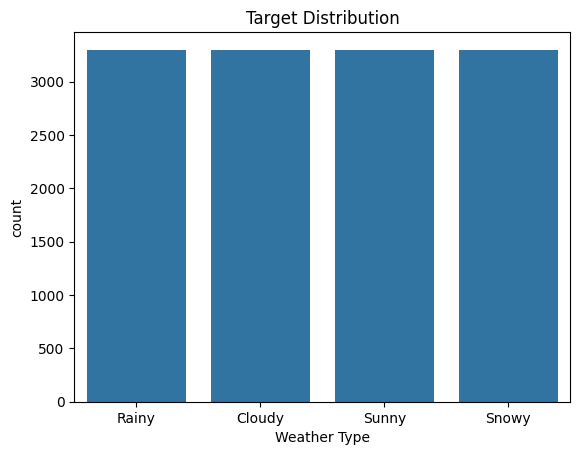

In [7]:
# 1. Is the target imbalanced?
def check_target_imbalance(df, target_column):
    print("Target Distribution:")
    print(df[target_column].value_counts(normalize=True))
    sns.countplot(x=df[target_column])
    plt.title("Target Distribution")
    plt.show()

# my note : here we ant to predict the weather so we will write the coulumn we eant to predict as a "target_column"

#check_target_imbalance(df, ??)
check_target_imbalance(df,'Weather Type')

##### No imbalance. So we can use Accuracy as a metric (we can show the others as well), and use KFold or StratifiedKFold for splitting later.
##### Note: When there is an imbalance, StratifiedKFold should be used to ensure representative validation sets. However, when there is no imbalance, StratifiedKFold is nearly equivalent to KFold, so it does not matter which one you use.

In [9]:
# 2. Do we have missing values?
def check_missing_values(df):
    missing_values = df.isnull().sum()
    print("Missing Values per Column:")
    print(missing_values[missing_values > 0])
    if missing_values.any():
        print("\nHandle Missing Values as needed.")
    else:
        print("\nNo Missing Values Found.")

#check_missing_values(??)
check_missing_values(df)

Missing Values per Column:
Series([], dtype: int64)

No Missing Values Found.


In [10]:
# 3. Do we have categorical columns?
def encode_categorical_columns(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    print("Categorical Columns:", list(categorical_cols))

label_encoders = encode_categorical_columns(df)

Categorical Columns: ['Cloud Cover', 'Season', 'Location', 'Weather Type']


##### We have several categorical columns. Let's encode them using Label Encoder.

In [12]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    print(f"Encoding column: {col}")
    le = LabelEncoder()
    #Fill in the code to encode the columns

    #df[col] = ??
    df[col] = le.fit_transform(df[col]) # same as the encoder code in day1

df

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,3,1010.82,2,3,3.5,1,1
1,39.0,96,8.5,71.0,3,1011.43,7,1,10.0,1,0
2,30.0,64,7.0,16.0,0,1018.72,5,1,5.5,2,3
3,38.0,83,1.5,82.0,0,1026.25,7,1,1.0,0,3
4,27.0,74,17.0,66.0,2,990.67,1,3,2.5,2,1
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,2,1003.15,1,2,1.0,2,1
13196,-1.0,76,3.5,23.0,1,1067.23,1,3,6.0,0,2
13197,30.0,77,5.5,28.0,2,1012.69,3,0,9.0,0,0
13198,3.0,76,10.0,94.0,2,984.27,0,3,2.0,1,2


In [13]:
# 4. Do we have duplicate samples?
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    print(f"Number of Duplicate Samples: {duplicates}")
    if duplicates > 0:
        print("Dropping Duplicates...")
        df.drop_duplicates(inplace=True)
        print("Duplicates Dropped.")
    else:
        print("No Duplicate Samples Found.")

check_duplicates(df)

Number of Duplicate Samples: 0
No Duplicate Samples Found.


##### If we have duplicates, we could use df = df.drop_duplicates().reset_index(drop=True) to drop them

In [14]:
# 5. Do we have different scales in the data?
df

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,3,1010.82,2,3,3.5,1,1
1,39.0,96,8.5,71.0,3,1011.43,7,1,10.0,1,0
2,30.0,64,7.0,16.0,0,1018.72,5,1,5.5,2,3
3,38.0,83,1.5,82.0,0,1026.25,7,1,1.0,0,3
4,27.0,74,17.0,66.0,2,990.67,1,3,2.5,2,1
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,2,1003.15,1,2,1.0,2,1
13196,-1.0,76,3.5,23.0,1,1067.23,1,3,6.0,0,2
13197,30.0,77,5.5,28.0,2,1012.69,3,0,9.0,0,0
13198,3.0,76,10.0,94.0,2,984.27,0,3,2.0,1,2


##### Yes, we have different scales, and we will use several algorithms that needs scaling.
##### Let's use MinMaxScaler to scale the data.

In [15]:
from sklearn.preprocessing import MinMaxScaler
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("Weather Type")  ### DON'T SCALE THE TARGET
scaler = MinMaxScaler()
#df[numerical_cols] = scaler.fit_transform(??)
df[numerical_cols] = scaler.fit_transform(df[numerical_cols]) #same as day1 too
df

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,0.291045,0.595506,0.195876,0.752294,1.000000,0.527951,0.142857,1.000000,0.175,0.5,1
1,0.477612,0.853933,0.175258,0.651376,1.000000,0.529480,0.500000,0.333333,0.500,0.5,0
2,0.410448,0.494382,0.144330,0.146789,0.000000,0.547746,0.357143,0.333333,0.275,1.0,3
3,0.470149,0.707865,0.030928,0.752294,0.000000,0.566614,0.500000,0.333333,0.050,0.0,3
4,0.388060,0.606742,0.350515,0.605505,0.666667,0.477461,0.071429,1.000000,0.125,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
13195,0.261194,0.606742,0.298969,0.651376,0.666667,0.508732,0.071429,0.666667,0.050,1.0,1
13196,0.179104,0.629213,0.072165,0.211009,0.333333,0.669298,0.071429,1.000000,0.300,0.0,2
13197,0.410448,0.640449,0.113402,0.256881,0.666667,0.532637,0.214286,0.000000,0.450,0.0,0
13198,0.208955,0.629213,0.206186,0.862385,0.666667,0.461425,0.000000,1.000000,0.100,0.5,2


#  Training our Classification Models

> We will need to first split up our data into an X array that contains the features to train on, and a y array with the target variable, in this case, the Weather Type column.

In [17]:
#X = df.drop("Weather Type",??)
X = df.drop("Weather Type",axis=1)

y = df['Weather Type']

> We will use StratifiedKFold to evaluate our models (Given data is balanced, you can use KFold or StratifiedKFold)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(kernel='rbf'),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=5),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100),
    "XGBoost Classifier": XGBClassifier(verbosity=0),
    "CatBoost Classifier": CatBoostClassifier(verbose=0)
}


for model_name, model in models.items():
    scores_accuracy = []
    scores_precision = []
    scores_recall = []
    scores_f1 = []

    # Stratified 5-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        # Split data into training and testing sets


        X_Train, X_Test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]


        # Train the model
        model.fit(X_Train, y_Train)
        # Predict on the test set
        y_pred = model.predict(X_Test)

        # Calculate metrics
        scores_accuracy.append(accuracy_score(y_Test, y_pred))
        scores_precision.append(precision_score(y_Test, y_pred, average='weighted'))
        scores_recall.append(recall_score(y_Test, y_pred, average='weighted'))
        scores_f1.append(f1_score(y_Test, y_pred, average='weighted'))

    # Print the results
    print(f"{model_name} Accuracy: {np.mean(scores_accuracy):.4f}")
    print(f"{model_name} Precision: {np.mean(scores_precision):.4f}")
    print(f"{model_name} Recall: {np.mean(scores_recall):.4f}")
    print(f"{model_name} F1-Score: {np.mean(scores_f1):.4f}")
    print("\n")


Logistic Regression Accuracy: 0.8523
Logistic Regression Precision: 0.8525
Logistic Regression Recall: 0.8523
Logistic Regression F1-Score: 0.8520


Support Vector Machine Accuracy: 0.9042
Support Vector Machine Precision: 0.9052
Support Vector Machine Recall: 0.9042
Support Vector Machine F1-Score: 0.9045


Decision Tree Classifier Accuracy: 0.9023
Decision Tree Classifier Precision: 0.9045
Decision Tree Classifier Recall: 0.9023
Decision Tree Classifier F1-Score: 0.9028


Random Forest Classifier Accuracy: 0.9139
Random Forest Classifier Precision: 0.9144
Random Forest Classifier Recall: 0.9139
Random Forest Classifier F1-Score: 0.9140


XGBoost Classifier Accuracy: 0.9152
XGBoost Classifier Precision: 0.9155
XGBoost Classifier Recall: 0.9152
XGBoost Classifier F1-Score: 0.9153


CatBoost Classifier Accuracy: 0.9138
CatBoost Classifier Precision: 0.9140
CatBoost Classifier Recall: 0.9138
CatBoost Classifier F1-Score: 0.9138




> * Is 91% Accuracy Good? We Need a Baseline.
>
> * What is the Simplest Baseline? Always predicting the majority class (e.g., if 80% of data is one class, accuracy = 80%).
>
> * If Our Model Beats the Baseline, It’s Good.


In [19]:
# Calculate the majority class baseline
majority_class = y.value_counts().idxmax()
baseline_pred = [majority_class] * len(y)

# Evaluate the baseline
baseline_accuracy = accuracy_score(y, baseline_pred)
baseline_precision = precision_score(y, baseline_pred, average='weighted')
baseline_recall = recall_score(y, baseline_pred, average='weighted')
baseline_f1 = f1_score(y, baseline_pred, average='weighted')

print(f"Baseline Accuracy (majority class): {baseline_accuracy:.4f}")
print(f"Baseline Precision (majority class): {baseline_precision:.4f}")
print(f"Baseline Recall (majority class): {baseline_recall:.4f}")
print(f"Baseline F1-Score (majority class): {baseline_f1:.4f}")


Baseline Accuracy (majority class): 0.2500
Baseline Precision (majority class): 0.0625
Baseline Recall (majority class): 0.2500
Baseline F1-Score (majority class): 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


> * Our models are significantly better than the baselines.
>
> * Let's Check what are the important features.

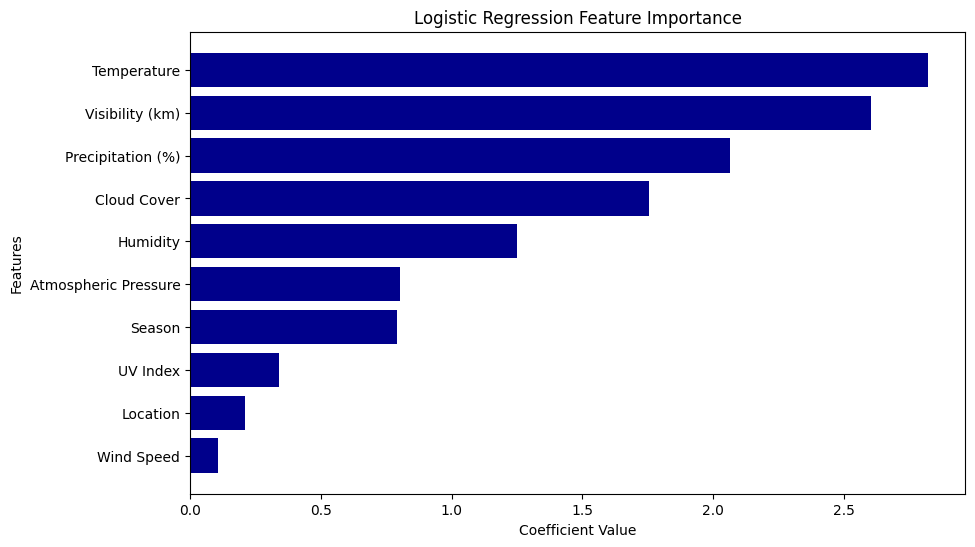

In [ ]:
# Retrieve Logistic Regression coefficients and sort by absolute importance
logistic_importance = list(zip(X.columns, models["Logistic Regression"].coef_[0]))
sorted_logistic_importance = sorted(logistic_importance, key=lambda x: abs(x[1]), reverse=True)

# Extract sorted features and their coefficients
features, coefficients = zip(*sorted_logistic_importance)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, np.abs(coefficients), color='darkblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Logistic Regression Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()


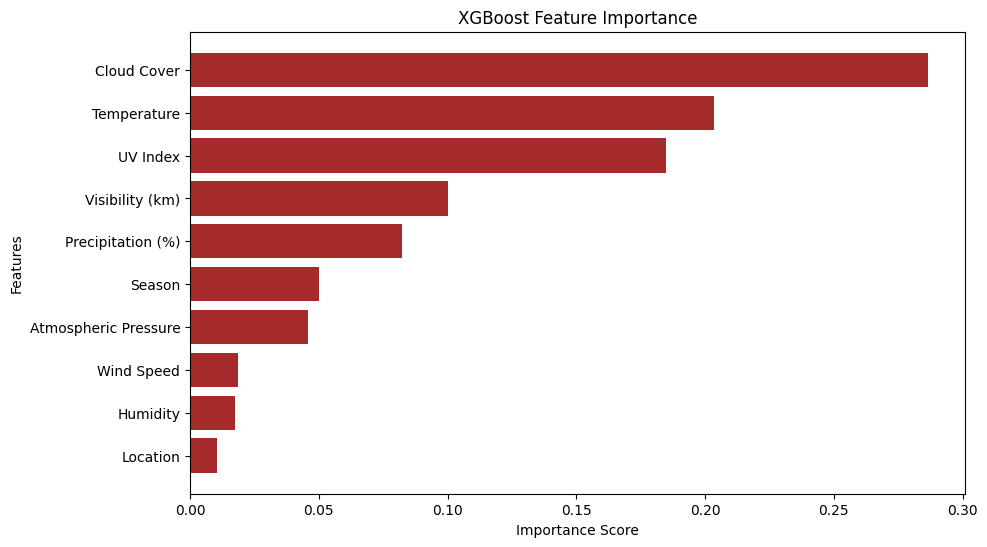

In [21]:
# Retrieve XGBoost feature importances
xgb_importances =  models["XGBoost Classifier"].feature_importances_

# Create a sorted list of feature importance
sorted_idx = np.argsort(xgb_importances)[::-1]
sorted_features = X.columns[sorted_idx]
sorted_importances = xgb_importances[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='brown')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()


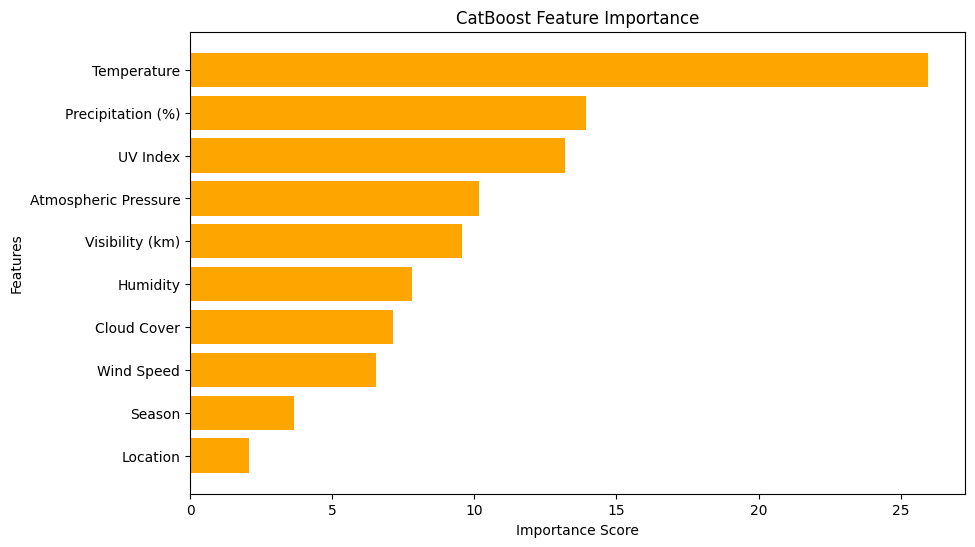

In [23]:
# Retrieve CatBoost feature importances and sort them
catboost_model = models["CatBoost Classifier"]
catboost_importance = list(zip(X.columns, catboost_model.feature_importances_))
sorted_catboost_importance = sorted(catboost_importance, key=lambda x: x[1], reverse=True)

# Extract features and their importances
features, importances = zip(*sorted_catboost_importance)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='orange')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()


## Final Notes:
> * Notice how different models depend on different features. "Cloud Cover" is the top feature for XGBoost while it is less important for the other models. (Do you think we could combine these models somehow to achieve even better results? Hint: Consider using something other than model.predict().)

> * Gradient Boosting algorithms (e.g., XGBoost, LightGBM, CatBoost) often outperform other algorithms in tabular data.


> * Want to improve performance even further? Try to do feature engineering and Hyperparameters tuning, and keep evaluating your work against the CV.

# Created by:
[Mohamed Eltayeb](https://www.kaggle.com/mohammad2012191)
